In [1]:
# Reference url: https://github.com/MJeremy2017/reinforcement-learning-implementation/blob/master/TicTacToe/ticTacToe.py 

## Play2,plyayer2 as human and play random selection,Player1 as computer

In [2]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

BOARD_ROWS = 3
BOARD_COLS = 3

In [3]:
class State:
    def __init__(self, p1, p2):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.p1 = p1
        self.p2 = p2
        self.isEnd = False
        self.boardHash = None
        # init p1 plays first
        self.playerSymbol = 1

    # get unique hash of current board state
    def getHash(self):
        self.boardHash = str(self.board.reshape(BOARD_COLS * BOARD_ROWS))
        return self.boardHash

    def winner(self):
        # row
        for i in range(BOARD_ROWS):
            if sum(self.board[i, :]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[i, :]) == -3:
                self.isEnd = True
                return -1
        # col
        for i in range(BOARD_COLS):
            if sum(self.board[:, i]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[:, i]) == -3:
                self.isEnd = True
                return -1
        # diagonal
        diag_sum1 = sum([self.board[i, i] for i in range(BOARD_COLS)])
        diag_sum2 = sum([self.board[i, BOARD_COLS - i - 1] for i in range(BOARD_COLS)])
        diag_sum = max(abs(diag_sum1), abs(diag_sum2))
        if diag_sum == 3:
            self.isEnd = True
            if diag_sum1 == 3 or diag_sum2 == 3:
                return 1
            else:
                return -1

        # tie
        # no available positions
        if len(self.availablePositions()) == 0:
            self.isEnd = True
            return 0
        # not end
        self.isEnd = False
        return None

    def availablePositions(self):
        positions = []
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                if self.board[i, j] == 0:
                    positions.append((i, j))  # need to be tuple
        return positions

    def updateState(self, position):
        self.board[position] = self.playerSymbol
        # switch to another player
        self.playerSymbol = -1 if self.playerSymbol == 1 else 1

    # only when game ends
    def giveReward(self):
        result = self.winner()
        # backpropagate reward
        if result == 1:
            self.p1.feedReward(1)
            self.p2.feedReward(0)
        elif result == -1:
            self.p1.feedReward(0)
            self.p2.feedReward(1)
        else:
            self.p1.feedReward(0.1)
            self.p2.feedReward(0.5)

    # board reset
    def reset(self):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.boardHash = None
        self.isEnd = False
        self.playerSymbol = 1

    def play(self, rounds=100):
        winlist = []
        for i in range(rounds):
            if i % 10000 == 0:
                print("Rounds {}".format(i))
            if i % 100 == 0:
                self.p1.setEps(rounds, i)
                self.p2.setEps(rounds, i)
            while not self.isEnd:
                # Player 1
                positions = self.availablePositions()
                p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
                # take action and upate board state
                self.updateState(p1_action)
                board_hash = self.getHash()
                self.p1.addState(board_hash)
                # check board status if it is end

                win = self.winner()
                if win is not None:
                    # self.showBoard()
                    # ended with p1 either win or draw
                    self.giveReward()
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break

                else:
                    # Player 2
                    positions = self.availablePositions()
                    p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
                    self.updateState(p2_action)
                    board_hash = self.getHash()
                    self.p2.addState(board_hash)

                    win = self.winner()
                    if win is not None:
                        # self.showBoard()
                        # ended with p2 either win or draw
                        self.giveReward()
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                        break
            winlist.append(win)
        return (winlist)
    # play with human
    def play2(self):
        while not self.isEnd:
            # Player 1
            positions = self.availablePositions()
            p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
            # take action and upate board state
            self.updateState(p1_action)
            #self.showBoard()
            # check board status if it is end
            win = self.winner()
            if win is not None:
                if win == 1:
                    self.reset()
                    return 1
                    #print(self.p1.name, "wins!")
                else:
                    self.reset()
                    return 0
                    #print("tie!")
                #self.reset()
                #break

            else:
                # Player 2
                positions = self.availablePositions()
                p2_action = self.p2.chooseAction(positions)

                self.updateState(p2_action)
                #self.showBoard()
                win = self.winner()
                if win is not None:
                    if win == -1:
                        self.reset()
                        return -1
                        #print(self.p2.name, "wins!")
                    else:
                        self.reset()
                        return 0
                        #print("tie!")
                    #self.reset()
                    #break
        return 0

    def showBoard(self):
        # p1: x  p2: o
        for i in range(0, BOARD_ROWS):
            print('-------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('-------------')


In [4]:
class Player:
    def __init__(self, name, eps_decay=False, start_exp_rate=0.3, end_exp_rate=0.05):
        self.name = name
        self.states = []  # record all positions taken
        self.lr = 0.2
        self.exp_rate = start_exp_rate
        
        self.decay_gamma = 0.9
        self.states_value = {}  # state -> value

        self.eps_decay = eps_decay
        self.start_exp_rate = start_exp_rate
        self.end_exp_rate = end_exp_rate
        
    def getHash(self, board):
        boardHash = str(board.reshape(BOARD_COLS * BOARD_ROWS))
        return boardHash
    
    def setEps(self, total_games, current_game):
        if (self.eps_decay == False):
            return
        else:
            self.exp_rate = self.start_exp_rate * (1. - current_game/total_games) + self.end_exp_rate * (current_game/total_games)
            if (np.mod(current_game, 1000) == 0):
                print ('decay rate modified at {} with current value of {}'.format(str(current_game), str(self.exp_rate)))
        return 

    def chooseAction(self, positions, current_board, symbol):
        if np.random.uniform(0, 1) <= self.exp_rate:
            # take random action
            idx = np.random.choice(len(positions))
            action = positions[idx]
        else:
            value_max = -999
            for p in positions:
                next_board = current_board.copy()
                next_board[p] = symbol
                next_boardHash = self.getHash(next_board)
                value = 0 if self.states_value.get(next_boardHash) is None else self.states_value.get(next_boardHash)
                # print("value", value)
                if value >= value_max:
                    value_max = value
                    action = p
        # print("{} takes action {}".format(self.name, action))
        return action

    # append a hash state
    def addState(self, state):
        self.states.append(state)

    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        for st in reversed(self.states):
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            self.states_value[st] += self.lr * (self.decay_gamma * reward - self.states_value[st])
            reward = self.states_value[st]

    def reset(self):
        self.states = []

    def savePolicy(self):
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()

    def loadPolicy(self, file):
        fr = open(file, 'rb')
        self.states_value = pickle.load(fr)
        fr.close()

In [5]:
def trainonce(p1, p2, games = 5000):
    width=1000 # for slicing data to plot
    
    st = State(p1, p2)
    print("training...")
    wl = st.play(games)

    p1.savePolicy()
    p2.savePolicy()
    
    # Analysis
    analysis = []
    nsteps = int(games/width)
    for i in range(nsteps):
        start = width*i
        end = width*(i+1) - 1
        #print (start, end)
        temp = wl[start:end]
        analysis.append([i, start, end, temp.count(1), temp.count(-1), temp.count(0)])

    andf = pd.DataFrame(analysis)
    andf.columns = ['batch', 'start', 'end', 'p1win', 'p2win', 'tie']
    andf['p1win'] = andf['p1win'].apply(lambda x: x/width)
    andf['p2win'] = andf['p2win'].apply(lambda x: x/width)
    andf['tie'] = andf['tie'].apply(lambda x: x/width)
    
    #title_string = 'Exploration rate is ' + str(eps)
    #print (title_string)
    # Plot 
    plt.plot(andf['batch'], andf['p1win'])
    plt.plot(andf['batch'], andf['p2win'])
    plt.plot(andf['batch'], andf['tie'])
    plt.legend(['p1 win', 'p2 win', 'tie'])
    #plt.title(title_string)
    plt.show()
    
    return

In [6]:
# set some parameters
start_exp_rate=0.3
end_exp_rate=0.05
games = 50000

training...
Rounds 0
Rounds 10000
Rounds 20000
Rounds 30000
Rounds 40000


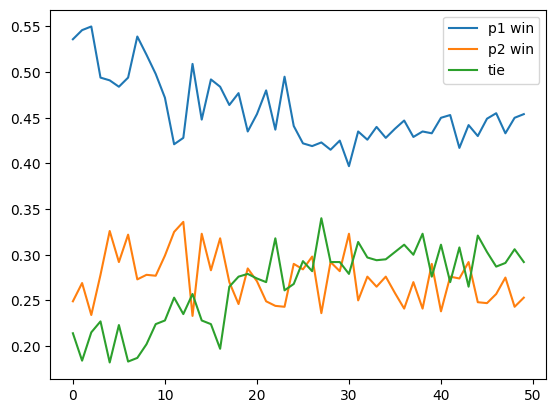

In [7]:
# Expt 1: Both P1 and P2 follow constant epsilon
# define P1 and P2 and then train 
p1 = Player("p1", eps_decay = False, start_exp_rate=start_exp_rate)
p2 = Player("p2", eps_decay = False, start_exp_rate=start_exp_rate)
trainonce(p1, p2, games=games)

training...
Rounds 0
decay rate modified at 0 with current value of 0.3
decay rate modified at 1000 with current value of 0.295
decay rate modified at 2000 with current value of 0.29
decay rate modified at 3000 with current value of 0.285
decay rate modified at 4000 with current value of 0.28
decay rate modified at 5000 with current value of 0.275
decay rate modified at 6000 with current value of 0.27
decay rate modified at 7000 with current value of 0.265
decay rate modified at 8000 with current value of 0.26
decay rate modified at 9000 with current value of 0.255
Rounds 10000
decay rate modified at 10000 with current value of 0.25
decay rate modified at 11000 with current value of 0.245
decay rate modified at 12000 with current value of 0.24
decay rate modified at 13000 with current value of 0.23500000000000001
decay rate modified at 14000 with current value of 0.23
decay rate modified at 15000 with current value of 0.22499999999999998
decay rate modified at 16000 with current value 

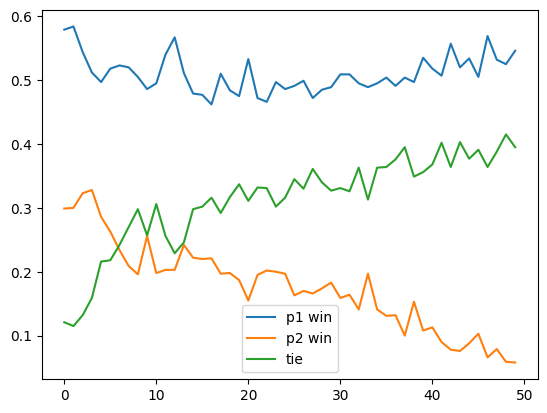

In [8]:
# Expt 2: P1 follows decaying epsilon and P2 follow constant epsilon
# define P1 and P2 and then train 
p1 = Player("p1", eps_decay = True, start_exp_rate=start_exp_rate, end_exp_rate=end_exp_rate)
p2 = Player("p2", eps_decay = False, start_exp_rate=start_exp_rate)
trainonce(p1, p2, games=games)

training...
Rounds 0
decay rate modified at 0 with current value of 0.3
decay rate modified at 0 with current value of 0.3
decay rate modified at 1000 with current value of 0.295
decay rate modified at 1000 with current value of 0.295
decay rate modified at 2000 with current value of 0.29
decay rate modified at 2000 with current value of 0.29
decay rate modified at 3000 with current value of 0.285
decay rate modified at 3000 with current value of 0.285
decay rate modified at 4000 with current value of 0.28
decay rate modified at 4000 with current value of 0.28
decay rate modified at 5000 with current value of 0.275
decay rate modified at 5000 with current value of 0.275
decay rate modified at 6000 with current value of 0.27
decay rate modified at 6000 with current value of 0.27
decay rate modified at 7000 with current value of 0.265
decay rate modified at 7000 with current value of 0.265
decay rate modified at 8000 with current value of 0.26
decay rate modified at 8000 with current val

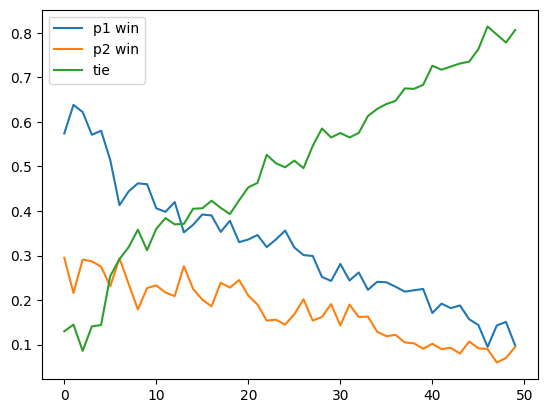

In [9]:
# Expt 3: both P1 and P2 follow decaying epsilon
# define P1 and P2 and then train 
p1 = Player("p1", eps_decay = True, start_exp_rate=start_exp_rate, end_exp_rate=end_exp_rate)
p2 = Player("p2", eps_decay = True, start_exp_rate=start_exp_rate, end_exp_rate=end_exp_rate)
trainonce(p1, p2, games=games)

In [10]:
import random
class HumanPlayer:
    def __init__(self, name):
        self.name = name

    def chooseAction(self, positions):
        return random.choice(positions) #random selection
    # append a hash state
    def addState(self, state):
        pass

    # at the end of game, backpropagate and update states value
    def feedReward(self, reward):
        pass

    def reset(self):
        pass


In [11]:
# Test the learning
# Test Method 1: Play against random player

def testgame(p1, p2, ngames):
    p1_wins = 0
    p2_wins = 0
    ties = 0

    for _ in range(ngames):
        state = State(p1, p2)  # Human (p2) plays first against Computer (p1)
        win = state.play2()  
        if win == 1:
            p1_wins += 1
        elif win == -1:
            p2_wins += 1
        else:
            ties += 1

    p1_win_probability = p1_wins / ngames
    p2_win_probability = p2_wins / ngames
    tie_probability = ties / ngames
    return p1_win_probability,p2_win_probability,tie_probability

In [12]:
# Test 1 - player trained with constant epsilon 
p1 = Player("Computer", start_exp_rate=0)
p1.loadPolicy("policy_p1_cp1_cp2")
p2 = HumanPlayer("RandomPlayer")
p1_win_probability,p2_win_probability,tie_probability=testgame(p1,p2, 1000)
print("Player 1 ({}): Winning Probability: {:.2%}".format(p1.name, p1_win_probability))
print("Player 2 ({}): Winning Probability: {:.2%}".format(p2.name, p2_win_probability))
print("Tie Probability: {:.2%}".format(tie_probability))

Player 1 (Computer): Winning Probability: 96.90%
Player 2 (RandomPlayer): Winning Probability: 3.10%
Tie Probability: 0.00%


In [13]:
# Test 2 - one player trained with decaying epsilon 
p1 = Player("Computer", start_exp_rate=0)
p1.loadPolicy("policy_p1_dp1_cp2")
p2 = HumanPlayer("RandomPlayer")
p1_win_probability,p2_win_probability,tie_probability=testgame(p1,p2, 1000)
print("Player 1 ({}): Winning Probability: {:.2%}".format(p1.name, p1_win_probability))
print("Player 2 ({}): Winning Probability: {:.2%}".format(p2.name, p2_win_probability))
print("Tie Probability: {:.2%}".format(tie_probability))

Player 1 (Computer): Winning Probability: 98.40%
Player 2 (RandomPlayer): Winning Probability: 0.00%
Tie Probability: 1.60%


In [14]:
# Test 3 - both players trained with decaying epsilon 
p1 = Player("Computer", start_exp_rate=0)
p1.loadPolicy("policy_p1_dp1_dp2")
p2 = HumanPlayer("RandomPlayer")
p1_win_probability,p2_win_probability,tie_probability=testgame(p1,p2, 1000)
print("Player 1 ({}): Winning Probability: {:.2%}".format(p1.name, p1_win_probability))
print("Player 2 ({}): Winning Probability: {:.2%}".format(p2.name, p2_win_probability))
print("Tie Probability: {:.2%}".format(tie_probability))

Player 1 (Computer): Winning Probability: 99.10%
Player 2 (RandomPlayer): Winning Probability: 0.00%
Tie Probability: 0.90%


In [15]:
# Test Method 2 - test trained players against each other